In [1]:
import requests as r
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [2]:
url_base_api_cartola = 'https://api.cartola.globo.com'
url_proximas_partidas = url_base_api_cartola + '/partidas'
url_atletas = url_base_api_cartola + '/atletas/mercado'

In [3]:
def get_proximas_partidas():
    response = r.get(url_proximas_partidas)
    if response.status_code == 200:
        return True, response.json()
    else:
        return False, False

In [4]:
def get_atletas():
    response = r.get(url_atletas)
    if response.status_code == 200:
        return True, response.json()
    else:
        return False, False

In [5]:
def cria_df_atletas():
    df_atletas = pd.DataFrame(columns=['Ano', 'Rodada', 'Clube', 'Posicao', 'Preco'])
    for ano in ['2018', '2019', '2020']:
        for rodada in range(1,39):
            df_rodadas_ano = pd.read_csv(f'cartola_dataset/{ano}/rodada-{rodada}.csv')
            df_rodadas_ano = df_rodadas_ano.rename(columns={
                'atletas.rodada_id': 'Rodada',
                'atletas.clube.id.full.name': 'Clube',
                'atletas.posicao_id': 'Posicao',
                'atletas.preco_num': 'Preco',
                'atletas.status_id': 'Status'
            })
            df_rodadas_ano = df_rodadas_ano[['Rodada', 'Clube', 'Posicao', 'Preco', 'Status']]
            df_rodadas_ano['Ano'] = ano
            df_atletas = df_atletas.append(df_rodadas_ano)
    
    for rodada in range(2,40):
           with open(f'cartola_dataset/2021/mercado_{rodada}.txt') as json_data:
                json_rodadas = json.load(json_data)
                for atleta in json_rodadas['atletas']:
                    json_input = {
                        'Ano': '2021',
                        'Rodada': rodada - 1,
                        'Clube': str(atleta['clube_id']),
                        'Posicao': atleta['posicao_id'],
                        'Preco': atleta['preco_num'],
                        'Status': atleta['status_id']
                    }
                    df_atletas = df_atletas.append(json_input, ignore_index=True)         
    return df_atletas

In [6]:
def formata_df_atletas(df, id_nome_time):
    id_posicao = pd.read_csv(f'cartola_dataset/posicoes_ids.csv')
    df['Clube'] = df['Clube'].replace(id_nome_time['id'].tolist(), id_nome_time['nome.cartola'].tolist())
    df['Posicao'] = df['Posicao'].replace(id_posicao['Cod'].tolist(), id_posicao['abbr'].tolist())
    df['Status'] = df['Status'].replace(7, 'Provável')
    return df

In [7]:
def cria_df_partidas():
    df_partidas = pd.DataFrame(columns=[
        'Ano', 'Rodada', 'Time_Casa', 'Time_Fora', 'Vencedor', 'Gols_Casa', 'Gols_Fora', 'Forca_Zag_Casa', 'Forca_Mei_Casa', 
        'Forca_Atk_Casa', 'Forca_Gol_Casa', 'Forca_Lat_Casa', 'Forca_Tec_Casa', 'Forca_Zag_Fora', 'Forca_Mei_Fora', 
        'Forca_Atk_Fora', 'Forca_Gol_Fora', 'Forca_Lat_Fora', 'Forca_Tec_Fora'
    ])
    
    for ano in ['2018', '2019', '2020', '2021']:
        with open (f'partidas_dataset/{ano}.json') as json_data:
            partidas_dados = json.load(json_data)
            for rodada in range(1, 39):
                jogos_rodada = partidas_dados[str(rodada)]
                for jogo in jogos_rodada:
                    json_input = {
                        'Ano': ano,
                        'Rodada': rodada,
                        'Time_Casa': jogo['clubs']['home'],
                        'Time_Fora': jogo['clubs']['away'],
                        'Gols_Casa': jogo['goals']['home'],
                        'Gols_Fora': jogo['goals']['away']
                    }
                    df_partidas = df_partidas.append(json_input, ignore_index=True)
    
    df_partidas['Vencedor'].mask(df_partidas['Gols_Casa'] > df_partidas['Gols_Fora'], 'Casa', inplace=True)
    df_partidas['Vencedor'].mask(df_partidas['Gols_Casa'] < df_partidas['Gols_Fora'], 'Fora', inplace=True)
    df_partidas['Vencedor'].mask(df_partidas['Gols_Casa'] == df_partidas['Gols_Fora'], 'Empate', inplace=True)
    return df_partidas

In [8]:
id_nome_time = pd.read_csv(f'cartola_dataset/id_nome_time.csv')
id_nome_time['id'] = id_nome_time['id'].astype(str)
df_atletas = cria_df_atletas()
df_atletas = formata_df_atletas(df_atletas, id_nome_time)
df_partidas = cria_df_partidas()

In [9]:
clubes = df_atletas['Clube'].unique().tolist()
anos = df_atletas['Ano'].unique().tolist()
rodadas = df_atletas['Rodada'].unique().tolist()

In [10]:
df_time_rodada = pd.DataFrame(columns=['Ano', 'Rodada', 'Clube', 'Forca_Zag', 'Forca_Mei', 'Forca_Atk', 'Forca_Gol', 'Forca_Lat', 'Forca_Tec'])

In [11]:
groups_atleta = df_atletas.groupby(['Ano', 'Rodada', 'Clube', 'Posicao']).describe()

In [12]:
for ano in anos:
    for rodada in rodadas:
        for nm_clube in clubes:
            clube = groups_atleta['Preco']['mean'][ano][rodada].get(nm_clube)
            if clube is not None:
                json_input = {
                    'Ano': ano,
                    'Rodada': rodada,
                    'Clube': nm_clube,
                    'Forca_Zag': clube.get('zag'),
                    'Forca_Mei': clube.get('mei'),
                    'Forca_Atk': clube.get('ata'),
                    'Forca_Gol': clube.get('gol'),
                    'Forca_Lat': clube.get('lat'),
                    'Forca_Tec': clube.get('tec')
                }
                df_time_rodada = df_time_rodada.append(json_input, ignore_index=True)

In [13]:
for linha in df_partidas.itertuples():
    df_casa = df_time_rodada[(df_time_rodada.Ano == linha[1]) & (df_time_rodada.Rodada == linha[2]) & (df_time_rodada.Clube == linha[3])]
    df_fora = df_time_rodada[(df_time_rodada.Ano == linha[1]) & (df_time_rodada.Rodada == linha[2]) & (df_time_rodada.Clube == linha[4])]
    df_partidas['Forca_Zag_Casa'][linha[0]] = df_casa['Forca_Zag'].tolist()[0] if df_casa['Forca_Zag'].tolist() else None
    df_partidas['Forca_Mei_Casa'][linha[0]] = df_casa['Forca_Mei'].tolist()[0] if df_casa['Forca_Mei'].tolist() else None
    df_partidas['Forca_Atk_Casa'][linha[0]] = df_casa['Forca_Atk'].tolist()[0] if df_casa['Forca_Atk'].tolist() else None
    df_partidas['Forca_Gol_Casa'][linha[0]] = df_casa['Forca_Gol'].tolist()[0] if df_casa['Forca_Gol'].tolist() else None
    df_partidas['Forca_Lat_Casa'][linha[0]] = df_casa['Forca_Lat'].tolist()[0] if df_casa['Forca_Lat'].tolist() else None
    df_partidas['Forca_Tec_Casa'][linha[0]] = df_casa['Forca_Tec'].tolist()[0] if df_casa['Forca_Tec'].tolist() else None
    df_partidas['Forca_Zag_Fora'][linha[0]] = df_fora['Forca_Zag'].tolist()[0] if df_fora['Forca_Zag'].tolist() else None
    df_partidas['Forca_Mei_Fora'][linha[0]] = df_fora['Forca_Mei'].tolist()[0] if df_fora['Forca_Mei'].tolist() else None
    df_partidas['Forca_Atk_Fora'][linha[0]] = df_fora['Forca_Atk'].tolist()[0] if df_fora['Forca_Atk'].tolist() else None
    df_partidas['Forca_Gol_Fora'][linha[0]] = df_fora['Forca_Gol'].tolist()[0] if df_fora['Forca_Gol'].tolist() else None
    df_partidas['Forca_Lat_Fora'][linha[0]] = df_fora['Forca_Lat'].tolist()[0] if df_fora['Forca_Lat'].tolist() else None
    df_partidas['Forca_Tec_Fora'][linha[0]] = df_fora['Forca_Tec'].tolist()[0] if df_fora['Forca_Tec'].tolist() else None

In [14]:
df_partidas = df_partidas.dropna(axis=0)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [16]:
X = df_partidas[['Forca_Zag_Casa','Forca_Mei_Casa','Forca_Atk_Casa','Forca_Gol_Casa','Forca_Lat_Casa','Forca_Tec_Casa','Forca_Zag_Fora','Forca_Mei_Fora','Forca_Atk_Fora','Forca_Gol_Fora','Forca_Lat_Fora','Forca_Tec_Fora']]
y = df_partidas['Vencedor']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [18]:
def treina_KNeighborsClassifier(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors = 100)
    knn.fit(X_train, y_train)
    print('Score KNeighborsClassifier:', knn.score(X_test, y_test))
    return knn

In [19]:
def treina_LogisticRegression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(multi_class='multinomial', max_iter=2000)
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    print('Score LogisticRegression:', accuracy_score(y_test, pred))
    return lr

In [20]:
def treina_LogisticRegression_clf(X_train, X_test, y_train, y_test):
    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
    search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)
    search.fit(X_train, y_train)
    clf = search.best_estimator_
    pred = clf.predict(X_test)
    print(f'Score LogisticRegression para clf {clf}: {accuracy_score(y_test, pred)}')
    return clf

In [21]:
def treina_SVC(X_train, X_test, y_train, y_test):
    svc = SVC(probability=True)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    print('Score SVC:', accuracy_score(y_test, pred))
    return svc

In [22]:
def treina_SVC_clf(X_train, X_test, y_train, y_test):
    param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    search = GridSearchCV(SVC(probability=True), param_grid)
    search.fit(X_train, y_train)
    clf = search.best_estimator_
    pred = clf.predict(X_test)
    print(f'Score SVC para clf {clf}: {accuracy_score(y_test, pred)}')
    return clf

In [23]:
def treina_DecisionTreeClassifier(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    print('Score DecisionTreeClassifier:', accuracy_score(y_test, pred))
    return dt

In [24]:
def treina_GaussianNB(X_train, X_test, y_train, y_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    pred = gnb.predict(X_test)
    print('Score GaussianNB:', accuracy_score(y_test, pred))
    return gnb

In [25]:
def treina_modelos(X_train, X_test, y_train, y_test):
    KNeighborsClassifier = treina_KNeighborsClassifier(X_train, X_test, y_train, y_test)
    LogisticRegression = treina_LogisticRegression(X_train, X_test, y_train, y_test)
    LogisticRegression_clf = treina_LogisticRegression_clf(X_train, X_test, y_train, y_test)
    SVC = treina_SVC(X_train, X_test, y_train, y_test)
    SVC_clf = treina_SVC_clf(X_train, X_test, y_train, y_test)
    DecisionTreeClassifier = treina_DecisionTreeClassifier(X_train, X_test, y_train, y_test)
    GaussianNB = treina_GaussianNB(X_train, X_test, y_train, y_test)
    return KNeighborsClassifier, LogisticRegression, LogisticRegression_clf, SVC, SVC_clf, GaussianNB

In [26]:
KNeighborsClassifier, LogisticRegression, LogisticRegression_clf, SVC, SVC_clf, GaussianNB = treina_modelos(X_train, X_test, y_train, y_test)

Score KNeighborsClassifier: 0.5423280423280423
Score LogisticRegression: 0.5370370370370371
Score LogisticRegression para clf LogisticRegression(C=0.01, max_iter=1000): 0.5502645502645502
Score SVC: 0.5502645502645502
Score SVC para clf SVC(C=1, probability=True): 0.5502645502645502
Score DecisionTreeClassifier: 0.43386243386243384
Score GaussianNB: 0.5238095238095238


In [27]:
response_proximas_partidas = get_proximas_partidas()
response_atletas = get_atletas()
if response_proximas_partidas[0]:
    proximas_partidas = response_proximas_partidas[1]['partidas']
else:
    print("Problema ao buscar próximas partidas")
if response_atletas[0]:
    atletas_rodada = response_atletas[1]['atletas']
else:
    print("Problema ao buscar atletas")

In [28]:
df_atletas_rodada = pd.DataFrame(atletas_rodada)
df_atletas_rodada = df_atletas_rodada[['clube_id', 'posicao_id', 'status_id', 'preco_num']]
df_proximas_partidas = pd.DataFrame(proximas_partidas)
df_proximas_partidas = df_proximas_partidas[['clube_casa_id', 'clube_visitante_id']]

In [29]:
id_posicao = pd.read_csv(f'cartola_dataset/posicoes_ids.csv')
df_atletas_rodada['Posicao'] = df_atletas_rodada['posicao_id'].replace(id_posicao['Cod'].tolist(), id_posicao['abbr'].tolist())
df_atletas_rodada['Status'] = df_atletas_rodada['status_id'].replace(7, 'Provável')

In [30]:
group_atletas_rodada = df_atletas_rodada.groupby(['clube_id', 'Posicao']).describe()

In [31]:
df_proximas_partidas['Forca_Zag_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['zag'], axis = 1)
df_proximas_partidas['Forca_Mei_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['mei'], axis = 1)
df_proximas_partidas['Forca_Atk_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['ata'], axis = 1)
df_proximas_partidas['Forca_Gol_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['gol'], axis = 1)
df_proximas_partidas['Forca_Lat_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['lat'], axis = 1)
df_proximas_partidas['Forca_Tec_Casa'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_casa_id]['tec'], axis = 1)
df_proximas_partidas['Forca_Zag_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['zag'], axis = 1)
df_proximas_partidas['Forca_Mei_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['mei'], axis = 1)
df_proximas_partidas['Forca_Atk_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['ata'], axis = 1)
df_proximas_partidas['Forca_Gol_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['gol'], axis = 1)
df_proximas_partidas['Forca_Lat_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['lat'], axis = 1)
df_proximas_partidas['Forca_Tec_Fora'] = df_proximas_partidas.apply(lambda row: group_atletas_rodada['preco_num']['mean'][row.clube_visitante_id]['tec'], axis = 1)

In [32]:
to_predict = df_proximas_partidas[['Forca_Zag_Casa','Forca_Mei_Casa','Forca_Atk_Casa','Forca_Gol_Casa','Forca_Lat_Casa','Forca_Tec_Casa','Forca_Zag_Fora','Forca_Mei_Fora','Forca_Atk_Fora','Forca_Gol_Fora','Forca_Lat_Fora','Forca_Tec_Fora']]

In [33]:
pred_KNeighbors = KNeighborsClassifier.predict_proba(to_predict)
pred_LogisticRegression = LogisticRegression_clf.predict_proba(to_predict)
pred_SVC = SVC.predict_proba(to_predict)

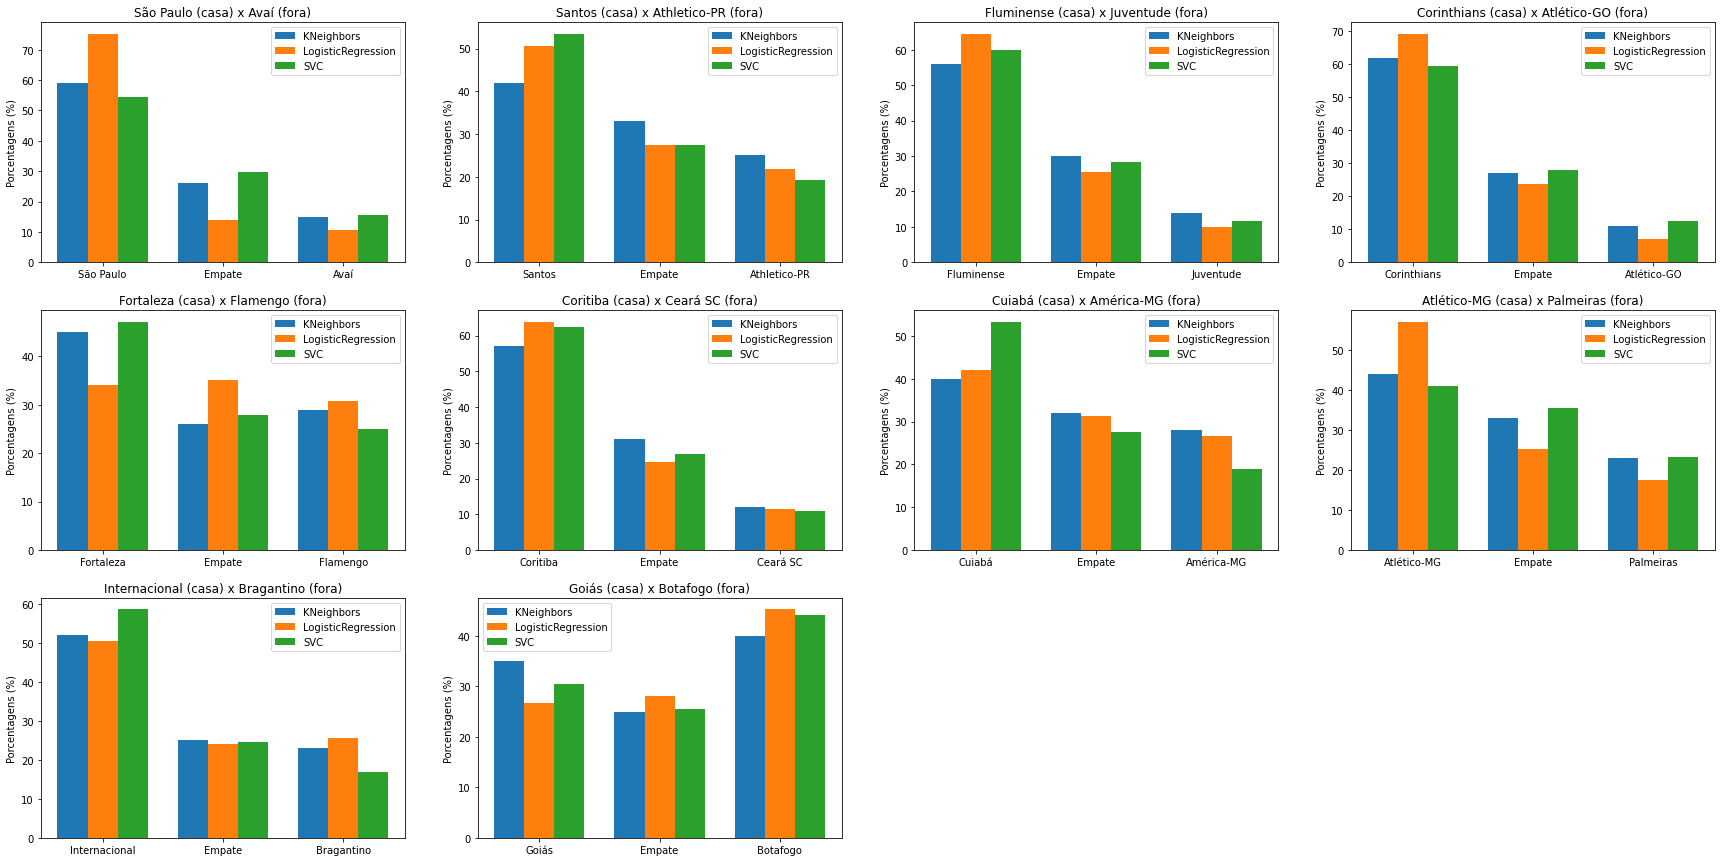

In [38]:
bar_width = 0.25
r1 = np.arange(3)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

for x in range(len(to_predict)):
    fig = plt.figure(0)
    plt.subplot2grid((3,4), (x//4, x%4))
    fig.set_figheight(15)
    fig.set_figwidth(30)
    percents_KNeighbors = [round(pred_KNeighbors[x][0] * 100, 2), round(pred_KNeighbors[x][1] * 100, 2), round(pred_KNeighbors[x][2] * 100, 2)]
    percents_LogisticRegression = [round(pred_LogisticRegression[x][0] * 100, 2), round(pred_LogisticRegression[x][1] * 100, 2), round(pred_LogisticRegression[x][2] * 100, 2)]
    percents_SVC = [round(pred_SVC[x][0] * 100, 2), round(pred_SVC[x][1] * 100, 2), round(pred_SVC[x][2] * 100, 2)]
    
    time_casa = id_nome_time[id_nome_time['id'] == str(df_proximas_partidas['clube_casa_id'][x])]['nome.cartola'].values[0]
    time_fora = id_nome_time[id_nome_time['id'] == str(df_proximas_partidas['clube_visitante_id'][x])]['nome.cartola'].values[0]
    
    plt.bar(r1, percents_KNeighbors, width=bar_width, label='KNeighbors')
    plt.bar(r2, percents_LogisticRegression, width=bar_width, label='LogisticRegression')
    plt.bar(r3, percents_SVC, width=bar_width, label='SVC')
    
    plt.xticks([r + bar_width for r in range(3)], [time_casa, 'Empate', time_fora])
    plt.ylabel('Porcentagens (%)')
    plt.title(f"{time_casa} (casa) x {time_fora} (fora)")
    plt.legend()
plt.savefig('result.png', format='png')
plt.show()

In [48]:
import smtplib
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
    
def send_email(user, pwd, recipient, subject):
    msg = MIMEMultipart()
    msg['From'] = user
    msg['To'] = recipient
    msg['Subject'] = subject
    with open('result.png', 'rb') as f:
        mime = MIMEImage(f.read(), _subtype='png')
    mime.add_header('Content-Disposition', 'attachment', filename='Result')
    msg.attach(mime)
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(user, pwd)
    server.sendmail(msg['From'], [msg['To']], msg.as_string())
    server.close()

In [49]:
send_email('', '', '', '')